In [1]:
# In this figure we invert Wang 2018 with least squares and plot the deviation of the invertion based on
# Random initial conditions. This is done to evaluate the robustness of the least squares inversion.

Run this code in a Work Station!!

You can test by reducing the number of seed and resolution.

Fist we call Wang 2018 and write a least square optimization

In [ ]:
from scipy.special import kv
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import loguniform

# Properties of the aquifer
freq = 1.932274 # Frequency in days
R_W = 0.2
R_C = 0.2
R = 0.2 # distance from the well m (only for drawdown computation)
B_AQ = 1 # Aquifer depth m
B_LE = 100 # Leaky layer depth m
SKEMPTON = 0.5 # Skempton's coefficient [-]
BULK = 20000000000.0 

# Wangs solution
def Wang(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq):

    omega = 2 * np.pi * freq

    betta = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5

    argument = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)

    xi = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2

    # water level

    h_w = argument / xi

    return np.abs(h_w), np.angle(h_w, deg=True)

 
#%%

def fit_amp_phase(vars):

    K_AQ, S_AQ, K_LE = vars

    Ar, dPhi = Wang(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq)
    
    res_amp = amp - Ar
    res_phase = ph - dPhi

    error = np.asarray([res_amp, res_phase])

    return error

# Uncomment the following two lines to test the method. Works nicely with days instead of seconds.
#amp, phase = Wang(1E-3*24*3600, 1E-5, 0, R_C, R_W, B_AQ, B_LE, freq)
#fit =  least_squares(fit_amp_phase, [1E-3*24*3600, 1E-5, 0], bounds=([1e-8*24*3600,1e-8, 0], [1e-2*24*3600,1e-3,1E-16]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
#################


# Now we have to make the loops 

# Define the number of samples and the resolution
numb = 25 # Resolution
no = 1000 # number of samples (seed)

res1 = np.zeros((numb, numb))
res2 = np.zeros((numb, numb))
res3 = np.zeros((numb, numb))

phase = np.linspace(90,-90,numb) # Phase range
amplitude = np.logspace(-3,0,numb) # Amplitude range

#Uncomment to test
#phase = np.linspace(-1.40414595254229,-1.40414595254229,1) # Phase range
#amp = np.linspace(0.9974209874047693,0.9974209874047693,1) # Amplitude range

for xu, m in enumerate(phase):
    print(xu)
    for nu, n in enumerate(amplitude):

        ph = m
        amp = n
        
        s_k = loguniform(1E-7, 1E-3).rvs(size=no) * 24*3600
        s_s = loguniform(1E-7, 1E-5).rvs(size=no)
        s_l = loguniform(1E-8, 1E-4).rvs(size=no) * 24*3600

        inv_k = np.zeros((no))
        inv_s = np.zeros((no))
        inv_l = np.zeros((no))

        for i, j in enumerate(s_k):
            fit =  least_squares(fit_amp_phase, (s_k[i], s_s[i], s_l[i]), bounds=([1E-7* 24*3600, 1E-7, 1E-8* 24*3600], [1E-3* 24*3600, 1E-5, 1E-4* 24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
            
            # Uncomment to test 
            #fit =  least_squares(fit_amp_phase, [1E-7*24*3600, 1E-8, 1E-5*24*3600], bounds=([1e-8*24*3600,1e-8, 1E-8*24*3600], [1e-2*24*3600,1e-3,1E-4*24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
            
            inv_k[i] = fit.x[0]
            inv_s[i] = fit.x[1]
            inv_l[i] = fit.x[2]
            
        res1[xu,nu] = np.abs((np.abs(inv_k.min())) - (np.abs(inv_k.max())))
        res2[xu,nu] = np.abs((np.abs(inv_s.min())) - (np.abs(inv_s.max())))
        res3[xu,nu] = np.abs((np.abs(inv_l.min())) - (np.abs(inv_l.max())))

    
np.savetxt('wang_2018_ka_25_1000_ws_2.csv', res1, delimiter=',')
np.savetxt('wang_2018_ss_25_1000_ws_2.csv', res2, delimiter=',')
np.savetxt('wang_2018_kl_25_1000_ws_2.csv', res3, delimiter=',')


Now we just need to plot

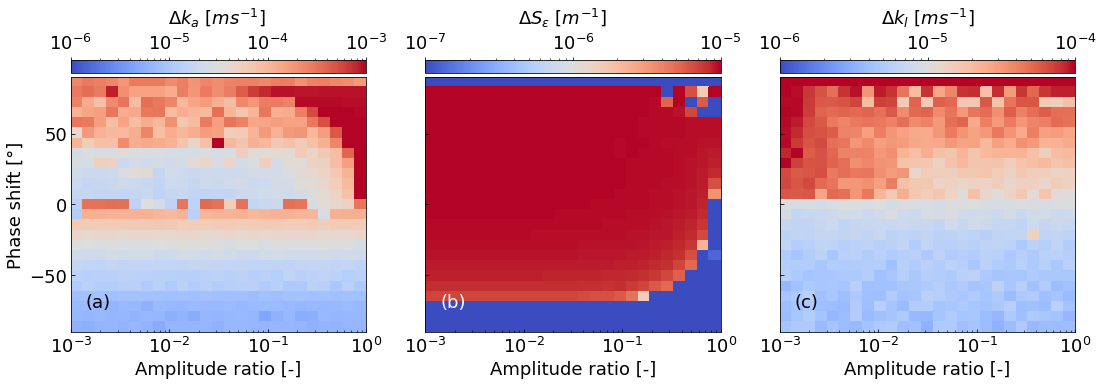

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import cm


k_1 = np.genfromtxt('wang_2018_ka_25_1000_ws_2.csv',delimiter=',')
s_1 = np.genfromtxt('wang_2018_ss_25_1000_ws_2.csv',delimiter=',')
l_1 = np.genfromtxt('wang_2018_kl_25_1000_ws_2.csv',delimiter=',')


plt.rcParams.update({'font.size': 18})
fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3, figsize = (18,5), sharey=True, facecolor='white')


plt.text(0.2, 0.98, '$\Delta k_a$ [$ms^{-1}$]', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.47, 0.98, '$\Delta S_{\epsilon}$ [$m^{-1}$]', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.75, 0.98, '$\Delta k_l$ [$ms^{-1}$]', fontsize=18, transform=plt.gcf().transFigure)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')


numb = 25
amplitude = np.logspace(-3,0,numb+1)
phase = np.linspace(90,-90,numb+1)
X,Y = np.meshgrid(amplitude,phase)

s_1[s_1 < 1E-7] = 1E-7

im1 = ax1.pcolor(X,Y,k_1/24/3600, norm=LogNorm(vmin=1E-6, vmax=1E-3), cmap='coolwarm')
im2 = ax2.pcolor(X,Y,s_1, norm=LogNorm(vmin=1E-7, vmax=1E-5), cmap='coolwarm')
im3 = ax3.pcolor(X,Y,l_1/24/3600, norm=LogNorm(vmin=1E-6, vmax=1E-4), cmap='coolwarm')

phase = np.linspace(0,-90,numb+1)
X,Y = np.meshgrid(amplitude,phase)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal',format=ticker.LogFormatterMathtext())
cax.xaxis.set_ticks_position("top")


divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size='5%', pad=0.05)
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal',format=ticker.LogFormatterMathtext())
cax.xaxis.set_ticks_position("top")

divider = make_axes_locatable(ax3)
cax = divider.append_axes('top', size='5%', pad=0.05)
cbar = fig.colorbar(im3, cax=cax, orientation='horizontal',format=ticker.LogFormatterMathtext())
cax.xaxis.set_ticks_position("top")

ax1.set_xlabel('Amplitude ratio [-]')
ax2.set_xlabel('Amplitude ratio [-]')
ax3.set_xlabel('Amplitude ratio [-]')

ax1.annotate('(a)', xy=(0.05, 0.1), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.1), xycoords='axes fraction', color='w')
ax3.annotate('(c)', xy=(0.05, 0.1), xycoords='axes fraction')

ax1.set_ylabel('Phase shift [°]')

fig.savefig('Figure_4.pdf', bbox_inches='tight')
